In [4]:
# --- test_segmentation_loss.ipynb cell ---
import sys
sys.path.append(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav")

import torch
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from modules.custom_loss import SegmentationVAELoss


[SegmentationVAELoss] Loaded 13 unique colors
[SegmentationVAELoss] ID range: 1001 - 9000
logits tensor shape: (1, 13, 512, 512)


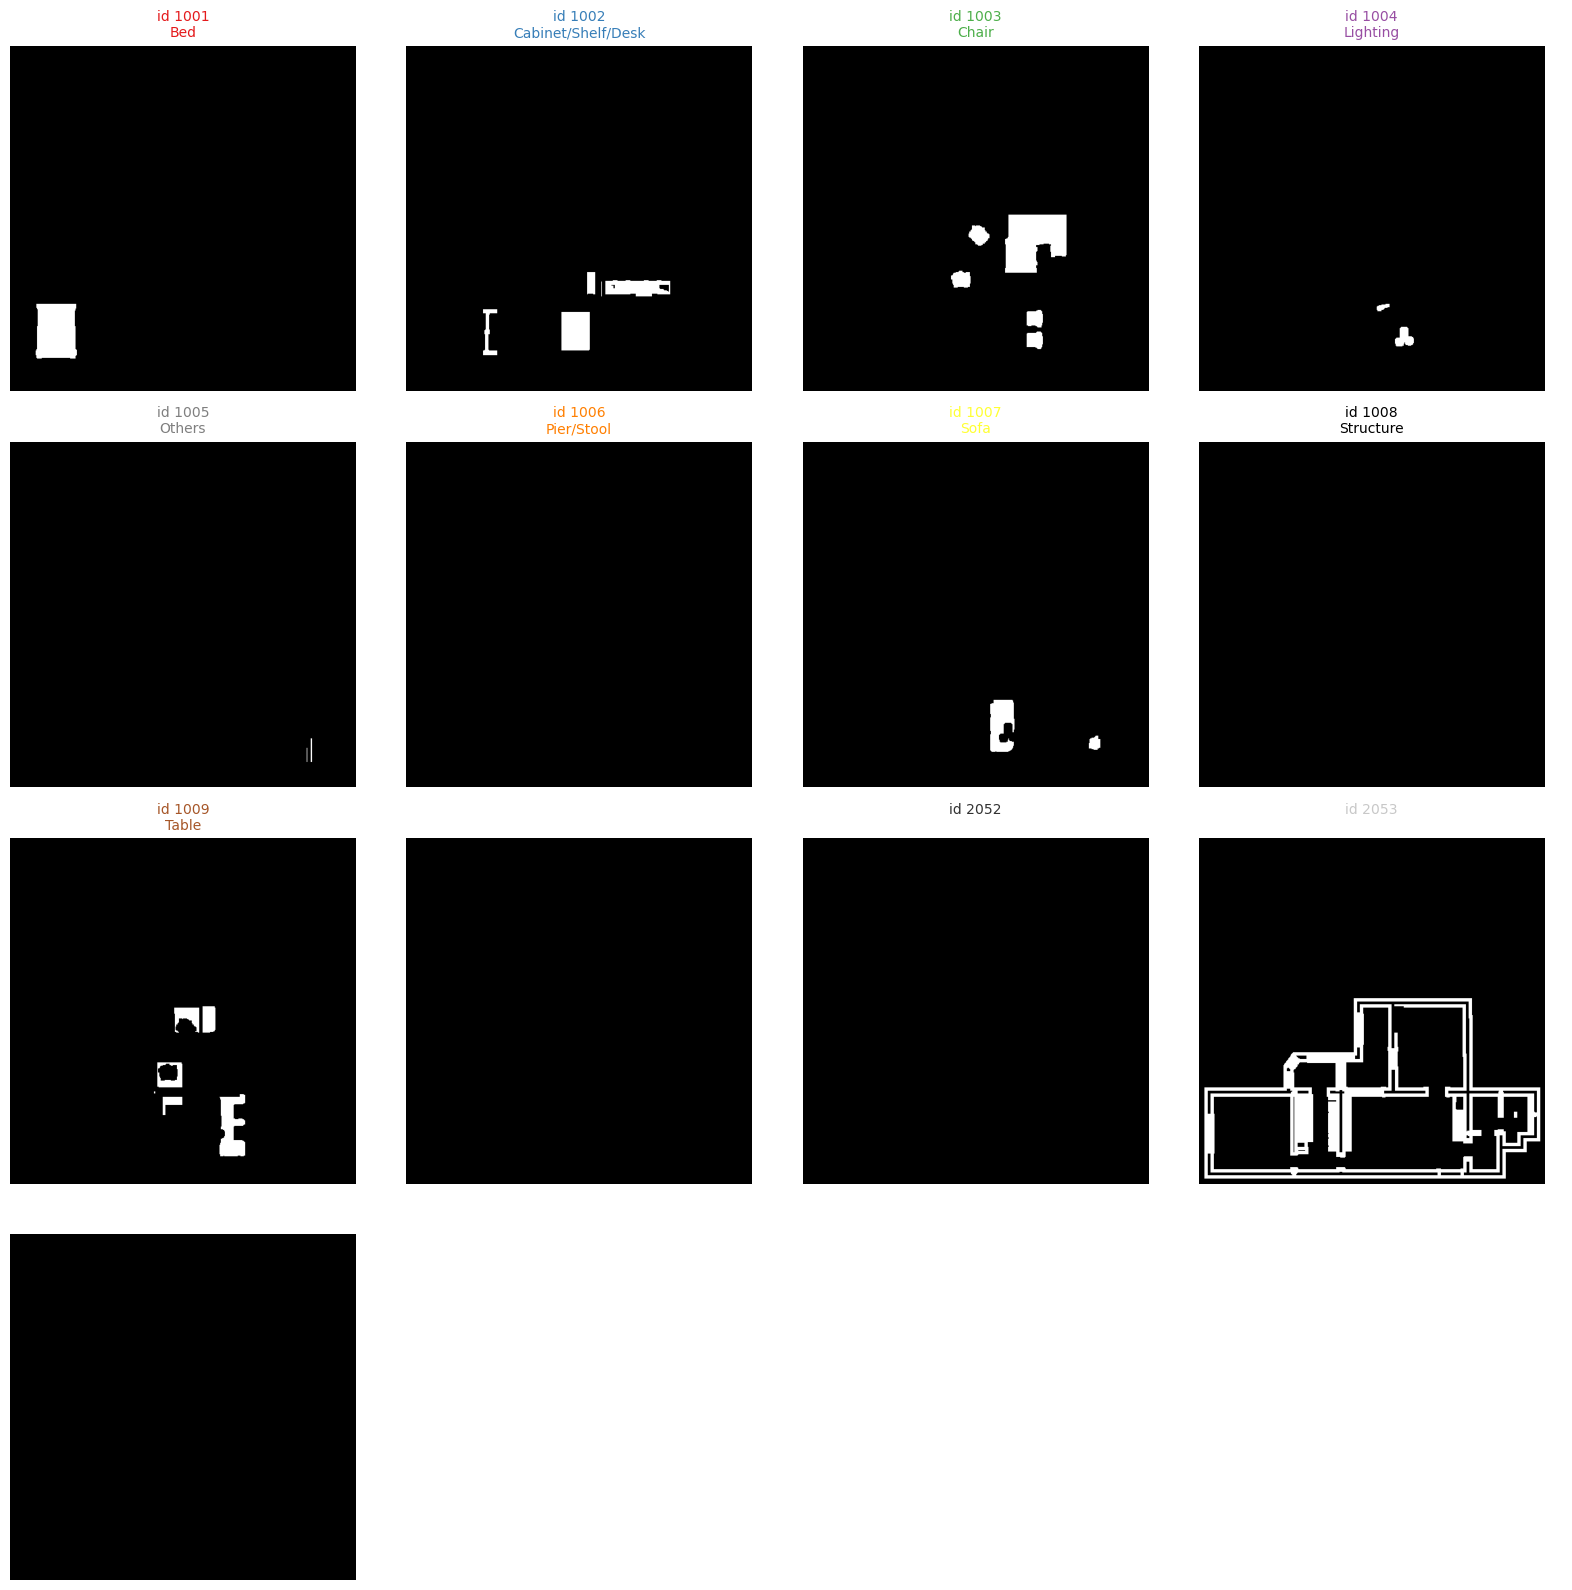

In [10]:
# --- segmentation_channel_breakdown.ipynb cell ---

import json
import torch
import numpy as np
from PIL import Image
from modules.custom_loss import SegmentationVAELoss

# 1. Load taxonomy.json
with open(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\config\taxonomy.json", "r", encoding="utf-8") as f:
    taxonomy = json.load(f)

id2color = taxonomy["id2color"]
id2super = taxonomy.get("id2super-category", taxonomy.get("id2super", {}))

# 2. Keep only valid classes (supercategories + structure + background)
valid_ids = [
    1001, 1002, 1003, 1004, 1005,
    1006, 1007, 1008, 1009,
    2051, 2052, 2053, 9000
]
filtered_id2color = {str(i): id2color[str(i)] for i in valid_ids if str(i) in id2color}
if "9000" not in filtered_id2color:
    filtered_id2color["9000"] = [255, 255, 255]

# 3. Instantiate SegmentationVAELoss
loss_fn = SegmentationVAELoss(id_to_color=filtered_id2color)

# 4. Load layout image
layout_path = r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\dataset\00add26c-7a26-4a61-b192-b97aa493b3f3\layouts\00add26c-7a26-4a61-b192-b97aa493b3f3_scene_layout.png"
img = Image.open(layout_path).convert("RGB")
img_np = np.array(img)
layout_rgb = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).float() / 255.0

# 5. Compute logits tensor
logits = loss_fn.layout_to_logits(layout_rgb)
num_classes = logits.shape[1]
print("logits tensor shape:", tuple(logits.shape))

# 6. Plot each channel as grayscale
cols = 4
rows = int(np.ceil(num_classes / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

id_list = sorted([int(k) for k in filtered_id2color.keys()])
for i, id_val in enumerate(id_list):
    r = i // cols
    c = i % cols
    ax = axes[r, c] if rows > 1 else axes[c]
    mask = logits[0, i].detach().cpu().numpy()
    color = np.array(filtered_id2color[str(id_val)]) / 255.0
    name = id2super.get(str(id_val), "")
    ax.imshow(mask, cmap="gray")
    ax.set_title(f"id {id_val}\n{name}", color=color, fontsize=10)
    ax.axis("off")

# Hide any unused subplots
for j in range(len(id_list), rows * cols):
    r = j // cols
    c = j % cols
    ax = axes[r, c] if rows > 1 else axes[c]
    ax.axis("off")

plt.tight_layout()
plt.show()